In [ ]:
import torch
import torchvision
import torchaudio
import random
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from tqdm.autonotebook import tqdm
import IPython.display as ipd
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_path = 'drive/MyDrive/images_original'

In [ ]:
batch_size = 8
image_size = 224

In [ ]:
train_trms = T.Compose([
                        T.Resize(image_size),
                        T.RandomRotation(20),
                        T.RandomHorizontalFlip(),
                        T.ToTensor()
                        ])
val_trms = T.Compose([
                        T.Resize(image_size),
                        T.ToTensor()
                        ])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root = img_path, transform = train_trms)
print(train_data.classes)
val_data = torchvision.datasets.ImageFolder(root = img_path, transform = val_trms)

In [ ]:
def Encode(data):
    classes = data.classes
    encoder = {}
    for i in range(len(classes)):
        encoder[i] = classes[i]
    return encoder

def Decoder(data):
    classes = data.classes
    
    decoder = {}
    for i in range(len(classes)):
        decoder[classes[i]] = i
    return decoder

In [ ]:
def class_plot(data,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        encoder = Encode(data)
        l = encoder[label]
       
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

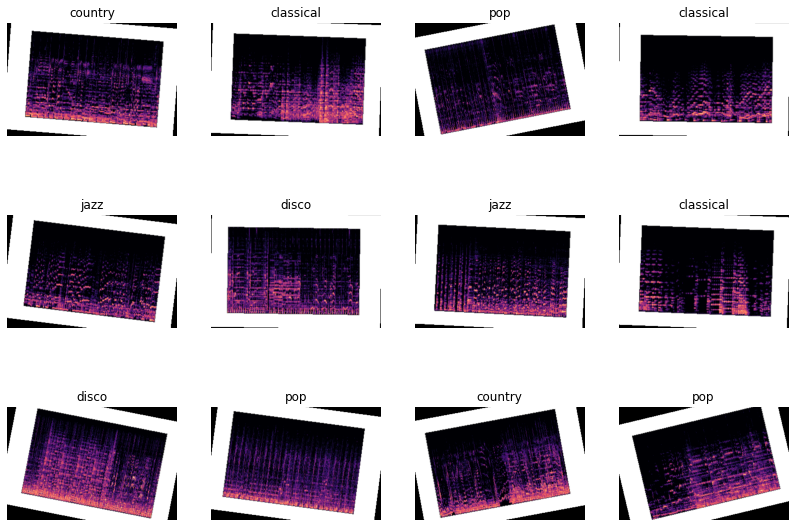

In [ ]:
class_plot(train_data)

In [ ]:
torch.manual_seed(43)
val_size = int(len(train_data)*0.1)
train_size = len(train_data) - val_size

In [ ]:
from torch.utils.data import random_split
train_ds, val_ds = random_split(train_data, [train_size,val_size])

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([8, 3, 224, 336])


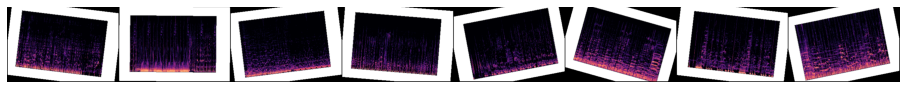

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['val_loss'], result['val_score']))

In [ ]:
class Net1(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            print("Here")
            
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
import torchvision.models as models
class Net(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return self.network(xb)
    def freeze(self):
      for param in self.network.parameters():
        param.require_grad = False
      for param in self.network.fc.parameters():
        param.require_grad = True
    
    def unfreeze(self):
      for param in self.network.parameters():
        param.require_grad = True

In [ ]:
Net()

Net(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model = to_device(Net(), device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
history = [evaluate(model, val_dl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model.freeze()

In [ ]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.1680, val_score: 0.2619


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 2.0065, val_score: 0.2589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6793, val_score: 0.4464


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.3274, val_score: 0.4911


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.3955, val_score: 0.5000
CPU times: user 1min 52s, sys: 1min 16s, total: 3min 9s
Wall time: 3min 20s


In [ ]:
torch.save(model.state_dict(), 'model_stable_1.pth')

In [ ]:
%%time
history += fit_one_cycle(15, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.4534, val_score: 0.5179


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.4857, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6843, val_score: 0.4762


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.4091, val_score: 0.5179


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.3841, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.4970, val_score: 0.4673


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.4014, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.2139, val_score: 0.5804


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.4654, val_score: 0.5357


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.4034, val_score: 0.5179


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.1868, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.2176, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.1058, val_score: 0.6012


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.0669, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.0252, val_score: 0.5982
CPU times: user 5min 38s, sys: 3min 46s, total: 9min 25s
Wall time: 10min 3s


In [ ]:
model.unfreeze()

In [ ]:
torch.save(model.state_dict(), 'model_stable_2.pth')

In [ ]:
%%time
history += fit_one_cycle(50, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.1761, val_score: 0.5446


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.1252, val_score: 0.5714


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.1701, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.2663, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.2556, val_score: 0.5625


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.2111, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.2472, val_score: 0.6042


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.4680, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.7117, val_score: 0.5000


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.2445, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.3703, val_score: 0.5387


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.5432, val_score: 0.4554


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.1183, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.5225, val_score: 0.5446


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.3038, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.4768, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.2716, val_score: 0.5446


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.6628, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.6005, val_score: 0.5268


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.0819, val_score: 0.6369


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.2727, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 0.9637, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.0623, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.1463, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.0993, val_score: 0.5714


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.5648, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.0518, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 1.5714, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.0266, val_score: 0.7054


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.1661, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.4699, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.1281, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.0503, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.3983, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.2443, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.3442, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.1048, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.1223, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.2331, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.2054, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 1.2546, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.2463, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.2239, val_score: 0.7202


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.3531, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.2566, val_score: 0.7202


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.4366, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.4961, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.2486, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.1394, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 1.3099, val_score: 0.6548
CPU times: user 18min 48s, sys: 12min 36s, total: 31min 25s
Wall time: 33min 27s


In [ ]:
torch.save(model.state_dict(), 'model3.pth')

In [ ]:
%%time
history += fit_one_cycle(100, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/113 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.5459, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1], val_loss: 1.3513, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2], val_loss: 1.6528, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3], val_loss: 1.3077, val_score: 0.7292


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4], val_loss: 1.5539, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5], val_loss: 1.5825, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6], val_loss: 1.2962, val_score: 0.6607


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7], val_loss: 1.3499, val_score: 0.7946


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8], val_loss: 1.4341, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9], val_loss: 1.2871, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10], val_loss: 1.5977, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11], val_loss: 1.4024, val_score: 0.6786


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12], val_loss: 1.7125, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13], val_loss: 1.7634, val_score: 0.5982


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14], val_loss: 1.7584, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15], val_loss: 1.1101, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16], val_loss: 1.3526, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17], val_loss: 1.4258, val_score: 0.6101


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18], val_loss: 1.4258, val_score: 0.6756


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19], val_loss: 1.2473, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20], val_loss: 1.5991, val_score: 0.5208


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [21], val_loss: 0.9619, val_score: 0.7143


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [22], val_loss: 1.4381, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [23], val_loss: 1.8831, val_score: 0.5982


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [24], val_loss: 1.4523, val_score: 0.6488


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [25], val_loss: 1.3689, val_score: 0.6310


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [26], val_loss: 1.2030, val_score: 0.7589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [27], val_loss: 2.0757, val_score: 0.5179


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [28], val_loss: 1.2511, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [29], val_loss: 1.3791, val_score: 0.6577


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [30], val_loss: 1.2425, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [31], val_loss: 1.4125, val_score: 0.5565


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [32], val_loss: 1.4237, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [33], val_loss: 1.1877, val_score: 0.5923


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [34], val_loss: 1.4232, val_score: 0.5714


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [35], val_loss: 1.0976, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [36], val_loss: 1.5341, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [37], val_loss: 1.3489, val_score: 0.7143


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [38], val_loss: 1.2231, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [39], val_loss: 1.3199, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [40], val_loss: 2.1011, val_score: 0.4911


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [41], val_loss: 1.5884, val_score: 0.6577


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [42], val_loss: 1.3336, val_score: 0.6667


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [43], val_loss: 1.4505, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [44], val_loss: 1.6539, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [45], val_loss: 1.6176, val_score: 0.6845


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [46], val_loss: 1.7601, val_score: 0.5625


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [47], val_loss: 1.7193, val_score: 0.5536


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [48], val_loss: 1.3846, val_score: 0.6190


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [49], val_loss: 2.0118, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [50], val_loss: 1.7365, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [51], val_loss: 1.5014, val_score: 0.6399


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [52], val_loss: 1.1800, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [53], val_loss: 1.3333, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [54], val_loss: 1.1906, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [55], val_loss: 1.4519, val_score: 0.6280


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [56], val_loss: 1.4417, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [57], val_loss: 1.5321, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [58], val_loss: 1.4480, val_score: 0.7024


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [59], val_loss: 1.5494, val_score: 0.5893


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [60], val_loss: 1.2690, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [61], val_loss: 1.3147, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [62], val_loss: 1.5862, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [63], val_loss: 1.5555, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [64], val_loss: 1.5153, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [65], val_loss: 1.2714, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [66], val_loss: 1.2151, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [67], val_loss: 1.9495, val_score: 0.6458


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [68], val_loss: 1.3256, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [69], val_loss: 1.5912, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [70], val_loss: 1.8828, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [71], val_loss: 1.3458, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [72], val_loss: 1.8767, val_score: 0.6339


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [73], val_loss: 1.4715, val_score: 0.6071


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [74], val_loss: 1.7970, val_score: 0.6161


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [75], val_loss: 1.3336, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [76], val_loss: 0.9953, val_score: 0.7589


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [77], val_loss: 1.3276, val_score: 0.7202


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [78], val_loss: 1.3591, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [79], val_loss: 1.5025, val_score: 0.7113


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [80], val_loss: 1.6201, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [81], val_loss: 1.4200, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [82], val_loss: 1.4598, val_score: 0.6548


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [83], val_loss: 1.3525, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [84], val_loss: 1.8269, val_score: 0.6994


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [85], val_loss: 1.5339, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [86], val_loss: 1.9005, val_score: 0.7083


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [87], val_loss: 1.4309, val_score: 0.6935


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [88], val_loss: 1.5421, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [89], val_loss: 1.5354, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [90], val_loss: 1.5152, val_score: 0.6637


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [91], val_loss: 1.8378, val_score: 0.6726


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [92], val_loss: 1.4945, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [93], val_loss: 1.7401, val_score: 0.6905


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [94], val_loss: 1.5880, val_score: 0.7470


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [95], val_loss: 1.6395, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [96], val_loss: 1.5671, val_score: 0.7381


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [97], val_loss: 2.0781, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [98], val_loss: 1.8006, val_score: 0.6815


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch [99], val_loss: 1.7657, val_score: 0.6815
CPU times: user 37min 18s, sys: 25min 43s, total: 1h 3min 2s
Wall time: 1h 6min 46s


In [ ]:
torch.save(model.state_dict(), '/content/model.pth')